In [18]:
# Tutoring myself with pytorch

import torch as t

x = t.rand(3, requires_grad = True)

y = x+2

z = y*y*2

z = z.mean()
y.retain_grad()
z.backward() # dz/dx

print(y.grad)

tensor([3.7199, 3.7495, 3.3422])


In [33]:
from imports import *

with open("data/pythia_val_data_b16.pkl", "rb") as f:
    val_dataloader = pickle.load(f)

model = LanguageModel("EleutherAI/pythia-70m", device_map = "cpu")

with model.trace(inputs["input_ids"]) as tracer:
    
    output_mlp = model.gpt_neox.layers[0].mlp.dense_4h_to_h.output.grad.save()
    output_attn = model.gpt_neox.layers[0].attention.dense.output.grad.save()
    
    
    model.output.logits.sum().backward()

print(output_mlp)
print();print()
print(output_attn)

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[[  74254.6016,   86240.3281,   32078.4414,  ...,  -40278.3633,
             3204.1621,   57686.4766],
         [ 127067.4062,  -75719.9141,   17110.9102,  ...,   34926.8320,
            97351.1016,   57586.2578],
         [ 395235.7812,  131617.2500,   31522.3418,  ...,  -33699.4609,
          -158051.6875,  -94951.6484],
         ...,
         [  16993.9863,  -20962.2891,   -5093.8003,  ...,  -19175.1406,
             3141.7490,   22179.5000],
         [  -8997.9590,  -10830.1123,   -1073.5027,  ...,   -2036.2819,
            -3130.4297,   -3082.9805],
         [  -2157.4988,  -13022.9834,  -10795.3965,  ...,   -7311.3613,
            -7002.0752,    5693.8853]]])


tensor([[[  74254.6016,   86240.3281,   32078.4414,  ...,  -40278.3633,
             3204.1621,   57686.4766],
         [ 127067.4062,  -75719.9141,   17110.9102,  ...,   34926.8320,
            97351.1016,   57586.2578],
         [ 395235.7812,  131617.2500,   31522.3418,  ...,  -33699.4609,
          -158051.6875

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from imports import *
from dataset import *

# Load the Pythia model and tokenizer
model = AutoModelForCausalLM.from_pretrained('EleutherAI/pythia-70m')
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/pythia-70m')
tokenizer.pad_token = tokenizer.eos_token

train_data, val_data = inspect_data(data)

# Sample input
input_text = 'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt. Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt." Together, they shared the needle and sewed the button on Lilys shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'
# inputs = tokenizer(input_text, return_tensors="pt")


# Define a list to store gradients per token


# Ensure the model is in evaluation mode
# model.eval()

final_data = []


for index, data in enumerate(tqdm(val_data["text"])):
    
    token_gradients = []
    
    inputs = tokenizer(data, return_tensors="pt", padding='max_length', max_length=128, truncation=True)

    # Get the outputs and compute loss
    outputs = model(**inputs)
    logits = outputs.logits
    loss = logits.sum()  # Example loss

    print(logits.shape)

    # Iterate over each token
    for token_idx in range(inputs["input_ids"].shape[1]):  # Loop over the sequence length (tokens)
        model.zero_grad()  # Clear any previous gradients
        
        # Compute loss only for this specific token's contribution
        # Modify this if needed to focus on the exact component of the loss related to the token
        token_loss = logits[0, token_idx, :].sum()
        
        # Perform backward pass
        token_loss.backward(retain_graph=True)  # retain_graph=True allows subsequent backward passes
        
        # Collect the gradient of the specific parameter for this token
        gradients = []
        for i in range(6):
            layer = model.gpt_neox.layers[i].mlp.dense_4h_to_h  # Access the specific layer/parameter (adapted to Pythia)
            param_grad = layer.weight.grad.clone().view(-1)  # Clone and reshape the gradient
            gradients.append(param_grad.unsqueeze(0))  # Append the gradient for this token

        # Convert gradients to a tensor and add to the list
        token_gradients.append(torch.cat(gradients, dim=0))  # Shape: (layer_count, output_dim)

    # Convert token gradients to a tensor for visualization
    token_gradients_tensor = torch.stack(token_gradients)  # Shape: (seq_len, layer_count, output_dim)

    # Compute the average gradient norm across layers for visualization
    average_gradients_tensor = torch.log(token_gradients_tensor.norm(dim=2))  # Shape: (seq_len, layer_count)

    final_data.append(average_gradients_tensor)

    print(np.array(final_data).shape)

    if index == 5:
        break


# Visualize the gradients using a heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(np.mean(np.array(final_data), axis = 0).T, cmap='viridis', cbar=True, yticklabels=range(6), xticklabels=range(average_gradients_tensor.size(0)))
plt.xlabel('Token Index')
plt.ylabel('Layer Index')
plt.title('Token-wise Gradient Norms Across Layers for mlp.dense_4h_to_h on log scale')
plt.show()
plt.close

/Users/maheepchaudhary/miniforge3/envs/transit/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


'Training set size: 2119719'
'Validation set size: 21990'
['text']
{'text': Value(dtype='string', id=None)}

'---------------------------------'



  0%|          | 0/21990 [00:00<?, ?it/s]

torch.Size([1, 128, 50304])


/Users/maheepchaudhary/miniforge3/envs/transit/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


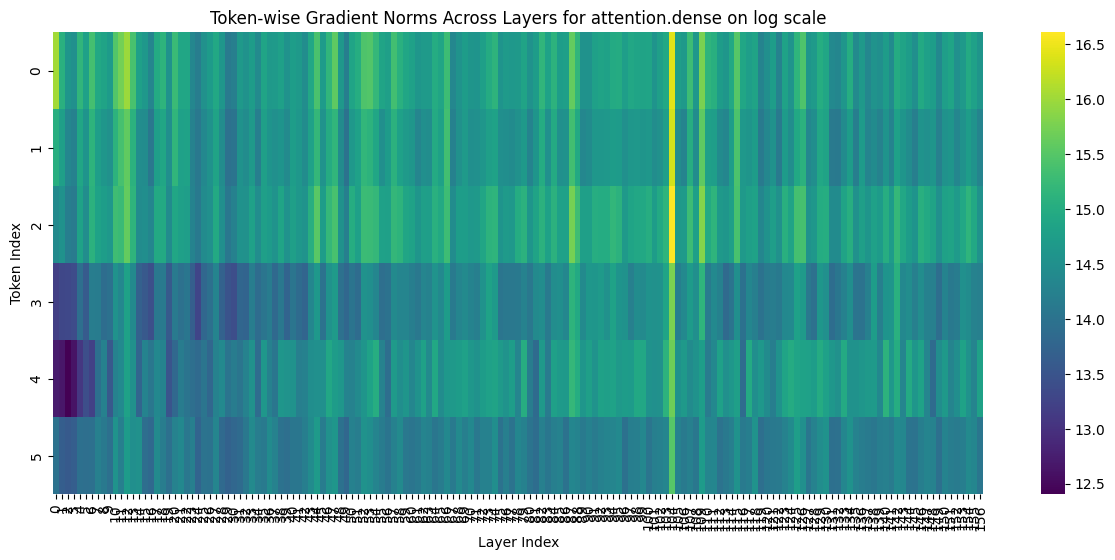

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the Pythia model and tokenizer
model = AutoModelForCausalLM.from_pretrained('EleutherAI/pythia-70m')
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/pythia-70m')

# Sample input
input_text = 'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt. Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt." Together, they shared the needle and sewed the button on Lilys shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'
inputs = tokenizer(input_text, return_tensors="pt")

# Define a list to store gradients per token
token_gradients = []

# Ensure the model is in evaluation mode
model.eval()

# Get the outputs and compute loss
outputs = model(**inputs)
logits = outputs.logits
loss = logits.sum()  # Example loss

# Iterate over each token
for token_idx in range(inputs["input_ids"].shape[1]):  # Loop over the sequence length (tokens)
    model.zero_grad()  # Clear any previous gradients
    
    # Compute loss only for this specific token's contribution
    # Modify this if needed to focus on the exact component of the loss related to the token
    token_loss = logits[0, token_idx, :].sum()
    
    # Perform backward pass
    token_loss.backward(retain_graph=True)  # retain_graph=True allows subsequent backward passes
    
    # Collect the gradient of the specific parameter for this token
    gradients = []
    for i in range(6):
        layer = model.gpt_neox.layers[i].attention.dense  # Access the specific layer/parameter (adapted to Pythia)
        param_grad = layer.weight.grad.clone().view(-1)  # Clone and reshape the gradient
        gradients.append(param_grad.unsqueeze(0))  # Append the gradient for this token

    # Convert gradients to a tensor and add to the list
    token_gradients.append(torch.cat(gradients, dim=0))  # Shape: (layer_count, output_dim)

# Convert token gradients to a tensor for visualization
token_gradients_tensor = torch.stack(token_gradients)  # Shape: (seq_len, layer_count, output_dim)

# Compute the average gradient norm across layers for visualization
average_gradients_tensor = torch.log(token_gradients_tensor.norm(dim=2))  # Shape: (seq_len, layer_count)

# Visualize the gradients using a heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(average_gradients_tensor.cpu().numpy().T, cmap='viridis', cbar=True, yticklabels=range(6), xticklabels=range(average_gradients_tensor.size(0)))
plt.xlabel('Layer Index')
plt.ylabel('Token Index')
plt.title('Token-wise Gradient Norms Across Layers for attention.dense on log scale')
plt.show()
plt.close()
